In [1]:
import pandas as pd
from varclushi import VarClusHi
import numpy as np

In [2]:
df=pd.read_pickle('prep_hist.pkl')

In [3]:
df

,linea,mesproceso,tiposuscripcion,descestatuslinea,antiglinea,modeloeq,monto,monto_prom,monto_min,monto_max,recargas
143785,2741227617,202002,PREPAGO,ACTIVO,34,ILIUM X220,200.0,66.67,50.0,100.0,3.0
143769,5510145001,202002,PREPAGO,ZERO BALANCE 1,2,1V 5001A,50.0,50.00,50.0,50.0,1.0
143714,8714127760,202002,PREPAGO,ACTIVO,51,GALAXY J1 2016 J120A,230.0,32.86,30.0,50.0,7.0
68939,8662055180,202002,PREPAGO,ACTIVO,9,E450F,200.0,28.57,20.0,30.0,7.0
68927,5559434454,202002,PREPAGO,ACTIVO,7,MOTO C XT1756,200.0,50.00,50.0,50.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
21438,3111559318,202108,PREPAGO,ZERO BALANCE 1,3,ONE XT1941-5,50.0,50.00,50.0,50.0,1.0
21356,4442076754,202108,PREPAGO,ACTIVO,0,NaN,NaN,NaN,NaN,NaN,NaN
21454,2228604643,202108,PREPAGO,ZERO BALANCE 1,8,AX687,70.0,35.00,20.0,50.0,2.0
21451,8117802343,202108,PREPAGO,ZERO BALANCE 1,2,GALAXY GRAND PRIME VE G531H,NaN,NaN,NaN,NaN,NaN


In [4]:
a=pd.Series(df['mesproceso'].unique()).reset_index()

In [5]:
a

,index,0
0,0,202002
1,1,202003
2,2,202004
3,3,202005
4,4,202006
5,5,202007
6,6,202008
7,7,202009
8,8,202010
9,9,202011


In [6]:
a.index=a[0]

In [10]:
df['mes']=df['mesproceso'].replace(dict(a['index']))

In [11]:
vobs , vdes = 6,2
anclai, anclaf = vobs-1,df['mes'].max()-vdes
anclai, anclaf

(5, 16)

In [12]:
for a in range(anclai,anclaf+1):
    print("observación: ",list(range(a-vobs+1,a+1)),'desempeño:', list(range(a+1,a+vdes+1)))

observación:  [0, 1, 2, 3, 4, 5] desempeño: [6, 7]
observación:  [1, 2, 3, 4, 5, 6] desempeño: [7, 8]
observación:  [2, 3, 4, 5, 6, 7] desempeño: [8, 9]
observación:  [3, 4, 5, 6, 7, 8] desempeño: [9, 10]
observación:  [4, 5, 6, 7, 8, 9] desempeño: [10, 11]
observación:  [5, 6, 7, 8, 9, 10] desempeño: [11, 12]
observación:  [6, 7, 8, 9, 10, 11] desempeño: [12, 13]
observación:  [7, 8, 9, 10, 11, 12] desempeño: [13, 14]
observación:  [8, 9, 10, 11, 12, 13] desempeño: [14, 15]
observación:  [9, 10, 11, 12, 13, 14] desempeño: [15, 16]
observación:  [10, 11, 12, 13, 14, 15] desempeño: [16, 17]
observación:  [11, 12, 13, 14, 15, 16] desempeño: [17, 18]


In [13]:
df[['monto','monto_prom','monto_min','monto_max','recargas']]=df[['monto','monto_prom','monto_min','monto_max','recargas']].fillna(0)

In [15]:
df['modeloeq']=df['modeloeq'].replace('(null)',np.nan)

In [17]:
df=df.drop_duplicates()

### Ingeniería de Variables

In [18]:
def ing_X(df,ancla,k):
    l = []
    aux = df.loc[(df['mes']<=ancla)&(df['mes']>=(ancla-k+1))]

    if k==vobs:
    # Registros durante  el periodo total de observación
        piv = aux.pivot_table(index='linea',
                         columns='mes',
                         values='monto',
                         aggfunc='count')
        piv[f'x_permanencia'] = piv.sum(axis=1)
        l.append(piv.filter(like='x_'))
    
    # Estatus durante periodo de observación
        piv = aux.pivot_table(index='linea',
                         columns='descestatuslinea',
                         values='monto',
                         aggfunc='count')
        piv.columns=['x_ACTIVO', 'x_ZERO BALANCE 1']
        l.append(piv)

    # Antiguedad línea en periodo final   
        piv = aux.pivot_table(index='linea',
                         columns='mes',
                         values='antiglinea',
                         aggfunc='sum')
        piv[f'x_antiglinea'] = piv.max(axis=1)
        l.append(piv.filter(like='x_'))

    #Cantidad de equipos diferentes en el periodo
    a=aux.groupby('linea')['modeloeq'].nunique()
    a.name=f'x_cambios_eq_{k}'
    l.append(a)    
    
    #Monto 
    piv = aux.pivot_table(index='linea',
                          columns='mes',
                          values='monto',
                          aggfunc='sum')
    piv[f'x_monto_recargado_{k}'] = piv.sum(axis=1)
    l.append(piv.filter(like='x_'))
    
    #Monto Promedio
    piv = aux.pivot_table(index='linea',
                          columns='mes',
                          values='monto',
                          aggfunc='sum')
    piv[f'x_monto_promedio_{k}'] = piv.mean(axis=1)
    l.append(piv.filter(like='x_'))
    
    #Promedio del promedio por recarga
    piv = aux.pivot_table(index='linea',
                          columns='mes',
                          values='monto_prom',
                          aggfunc='sum')
    piv[f'x_prom_recarga_{k}'] = piv.mean(axis=1)
    l.append(piv.filter(like='x_'))
    
    #Suma de promedio por recarga 
    piv = aux.pivot_table(index='linea',
                          columns='mes',
                          values='monto_prom',
                          aggfunc='sum')
    piv[f'x_sum_prom_recarga_{k}'] = piv.sum(axis=1)
    l.append(piv.filter(like='x_'))
        
    #Mínimo de monto 
    piv = aux.pivot_table(index='linea',
                          columns='mes',
                          values='monto',
                          aggfunc='sum')
    piv[f'x_min_monto_{k}'] = piv.min(axis=1)
    l.append(piv.filter(like='x_'))
    
    #Máximo de monto 
    piv = aux.pivot_table(index='linea',
                          columns='mes',
                          values='monto',
                          aggfunc='sum')
    piv[f'x_max_monto_{k}'] = piv.max(axis=1)
    l.append(piv.filter(like='x_'))
    
    #Promedio de recarga mínima 
    piv = aux.pivot_table(index='linea',
                          columns='mes',
                          values='monto_min',
                          aggfunc='sum')
    piv[f'x_min_recarga_{k}'] = piv.mean(axis=1)
    l.append(piv.filter(like='x_'))
    
    #Promedio de recarga máxima
    piv = aux.pivot_table(index='linea',
                          columns='mes',
                          values='monto_max',
                          aggfunc='sum')
    piv[f'x_max_recarga_{k}'] = piv.mean(axis=1)
    l.append(piv.filter(like='x_'))    

    #Promedio recargas mensuales
    piv = aux.pivot_table(index='linea',
                          columns='mes',
                          values='recargas',
                          aggfunc='sum')
    piv[f'x_recargas_prom_{k}'] = piv.mean(axis=1)
    l.append(piv.filter(like='x_'))    
    
    #Total de recargas
    piv = aux.pivot_table(index='linea',
                          columns='mes',
                          values='recargas',
                          aggfunc='sum')
    piv[f'x_recargas_{k}'] = piv.sum(axis=1)
    l.append(piv.filter(like='x_'))    
    
      
    aux = reduce(lambda x,y:pd.merge(x,
                                      y,
                                      left_index=True,
                                      right_index=True,
                                      how='outer'),l).reset_index()
    aux.insert(1,'ancla',ancla)
    
    return aux

In [19]:
from functools import reduce

In [20]:
step = 3

In [21]:
um = ['linea','ancla']

In [22]:
cruzar = lambda x,y:pd.merge(x,y,on=um,how='outer')
apilar = lambda x,y:x.append(y,ignore_index=True)

In [23]:
X = reduce(apilar, map(lambda ancla:reduce(cruzar, map(lambda k:ing_X(df,ancla,k), range(step,vobs+step,step)) ),range(anclai,anclaf+1)))

In [25]:
X['x_permanencia'].value_counts()

6.0    46986
1.0    16670
2.0    15871
3.0    15426
4.0    15124
5.0    14178
Name: x_permanencia, dtype: int64

In [26]:
X=X[(X['x_permanencia']==vobs)]

## Variable Objetivo

In [28]:
def ing_y(df,ancla):
    l = []
    aux = df.loc[(df['mes']>ancla)&(df['mes']<=(ancla+vdes))][['linea']].drop_duplicates().reset_index(drop=True).assign(churn=0)
    aux.insert(1,'ancla',ancla)
    return aux

In [29]:
y = reduce(apilar,map(lambda ancla:ing_y(df,ancla),range(anclai,anclaf+1)))

In [30]:
tad = X.merge(y,on=um,how='left')
tad['churn'].fillna(1,inplace=True)
tad['churn'].value_counts(True)

0.0    0.83095
1.0    0.16905
Name: churn, dtype: float64

In [31]:
tad['churn'].value_counts()

0.0    39043
1.0     7943
Name: churn, dtype: int64

In [32]:
varc = sorted(tad.filter(like='x_').columns)
vart = ['churn']

In [33]:
varc.remove('x_permanencia')

In [34]:
tad

,linea,ancla,x_cambios_eq_3,x_monto_recargado_3,x_monto_promedio_3,x_prom_recarga_3,x_sum_prom_recarga_3,x_min_monto_3,x_max_monto_3,x_min_recarga_3,...,x_monto_promedio_6,x_prom_recarga_6,x_sum_prom_recarga_6,x_min_monto_6,x_max_monto_6,x_min_recarga_6,x_max_recarga_6,x_recargas_prom_6,x_recargas_6,churn
0,2211041593,5,2.0,310.0,103.333333,26.000000,78.00,0.0,190.0,16.666667,...,86.666667,24.666667,148.00,0.0,190.0,16.666667,33.333333,2.333333,14.0,0.0
1,2211049487,5,1.0,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,...,61.666667,6.833333,41.00,0.0,210.0,6.666667,8.333333,3.000000,18.0,0.0
2,2211077018,5,1.0,50.0,16.666667,16.666667,50.00,0.0,30.0,16.666667,...,33.333333,22.083333,132.50,0.0,90.0,21.666667,23.333333,1.333333,8.0,0.0
3,2211090475,5,1.0,0.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,...,11.666667,11.666667,70.00,0.0,50.0,11.666667,11.666667,0.333333,2.0,0.0
4,2211094929,5,1.0,900.0,300.000000,37.473333,112.42,60.0,570.0,10.000000,...,173.333333,24.570000,147.42,0.0,570.0,6.666667,33.333333,4.333333,26.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46981,9995073480,16,1.0,550.0,183.333333,61.113333,183.34,150.0,200.0,50.000000,...,171.666667,56.806667,340.84,100.0,230.0,46.666667,75.000000,3.000000,18.0,0.0
46982,9995844317,16,1.0,150.0,50.000000,25.000000,75.00,0.0,150.0,16.666667,...,58.333333,20.833333,125.00,0.0,200.0,16.666667,25.000000,1.000000,6.0,0.0
46983,9996402823,16,1.0,140.0,46.666667,26.666667,80.00,20.0,90.0,26.666667,...,58.333333,26.666667,160.00,0.0,150.0,26.666667,26.666667,1.666667,10.0,1.0
46984,9996696718,16,1.0,200.0,66.666667,50.000000,150.00,50.0,100.0,50.000000,...,58.333333,50.000000,300.00,50.0,100.0,50.000000,50.000000,1.166667,7.0,1.0


### Análisis Exploratorio

array([[<AxesSubplot:title={'center':'x_ACTIVO'}>,
        <AxesSubplot:title={'center':'x_ZERO BALANCE 1'}>,
        <AxesSubplot:title={'center':'x_antiglinea'}>,
        <AxesSubplot:title={'center':'x_cambios_eq_3'}>,
        <AxesSubplot:title={'center':'x_cambios_eq_6'}>],
       [<AxesSubplot:title={'center':'x_max_monto_3'}>,
        <AxesSubplot:title={'center':'x_max_monto_6'}>,
        <AxesSubplot:title={'center':'x_max_recarga_3'}>,
        <AxesSubplot:title={'center':'x_max_recarga_6'}>,
        <AxesSubplot:title={'center':'x_min_monto_3'}>],
       [<AxesSubplot:title={'center':'x_min_monto_6'}>,
        <AxesSubplot:title={'center':'x_min_recarga_3'}>,
        <AxesSubplot:title={'center':'x_min_recarga_6'}>,
        <AxesSubplot:title={'center':'x_monto_promedio_3'}>,
        <AxesSubplot:title={'center':'x_monto_promedio_6'}>],
       [<AxesSubplot:title={'center':'x_monto_recargado_3'}>,
        <AxesSubplot:title={'center':'x_monto_recargado_6'}>,
        <AxesSub

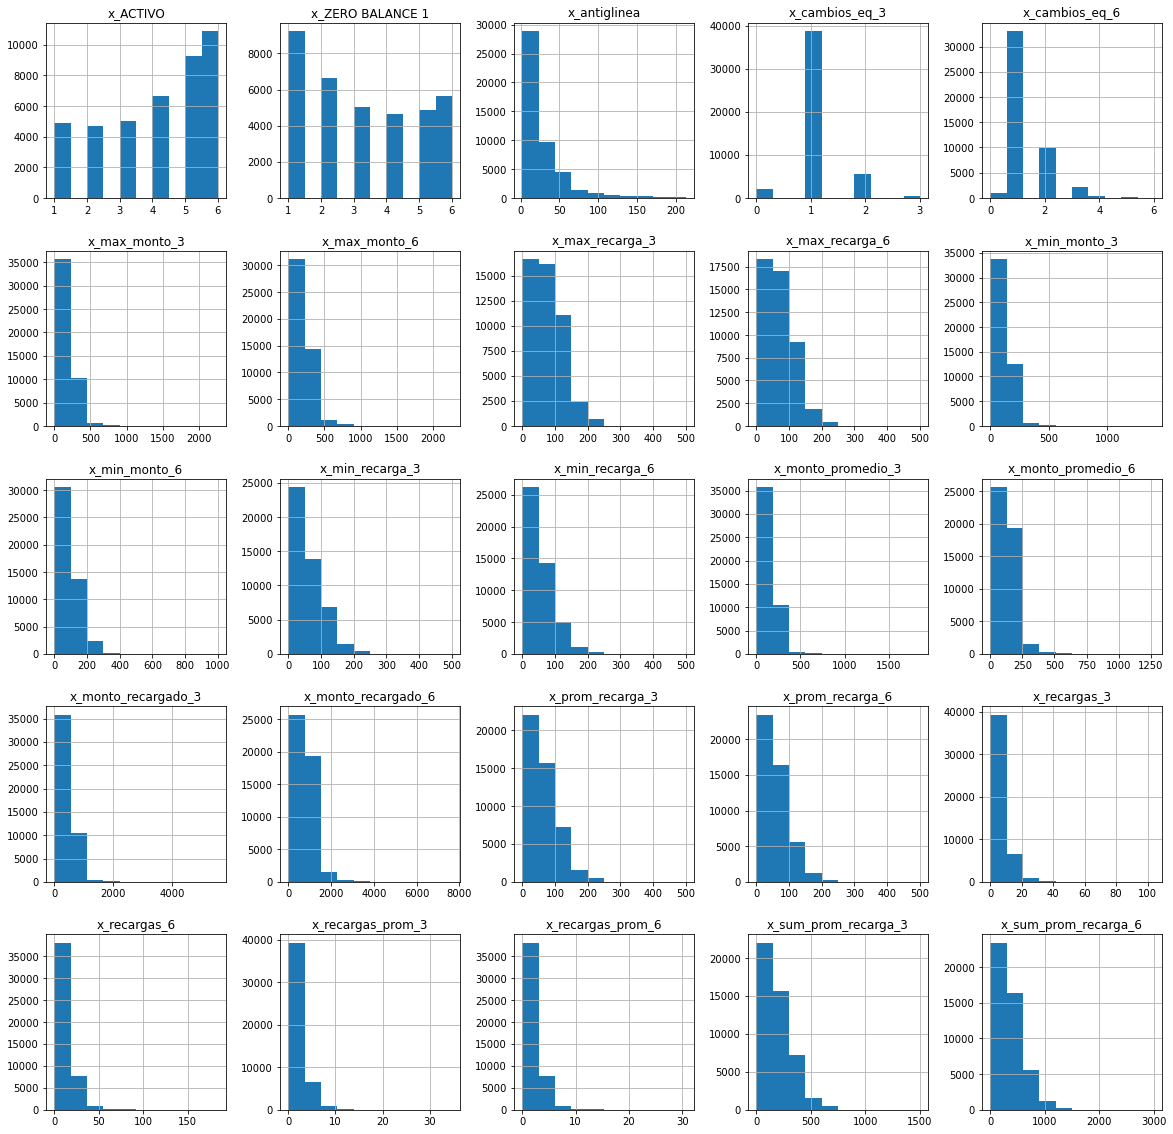

In [35]:
tad[varc].hist(figsize=(20,20))

In [39]:
tad[varc]=tad[varc].fillna(0)

## Multicolinealidad

In [40]:
vc = VarClusHi(df=tad,feat_list=varc)
vc.varclus()
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount()+1
best = rs.loc[rs['id']==1]['Variable'].tolist()
best

['x_prom_recarga_3',
 'x_monto_recargado_3',
 'x_recargas_prom_3',
 'x_ACTIVO',
 'x_antiglinea']

In [41]:
rs

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio,id
0,0,x_prom_recarga_3,0.973499,0.400549,4.420848e-02,1
1,0,x_sum_prom_recarga_3,0.973499,0.400549,4.420848e-02,2
2,0,x_sum_prom_recarga_6,0.973944,0.431906,4.586599e-02,3
3,0,x_prom_recarga_6,0.973944,0.431906,4.586599e-02,4
4,0,x_min_recarga_6,0.933344,0.370641,1.059102e-01,5
5,0,x_min_recarga_3,0.923249,0.338183,1.159695e-01,6
6,0,x_max_recarga_6,0.930619,0.463098,1.292255e-01,7
7,0,x_max_recarga_3,0.920465,0.466400,1.490532e-01,8
8,1,x_monto_recargado_3,0.965262,0.508337,7.065420e-02,1
9,1,x_monto_promedio_3,0.965262,0.508337,7.065420e-02,2


array([[<AxesSubplot:title={'center':'x_prom_recarga_3'}>,
        <AxesSubplot:title={'center':'x_monto_recargado_3'}>],
       [<AxesSubplot:title={'center':'x_recargas_prom_3'}>,
        <AxesSubplot:title={'center':'x_ACTIVO'}>],
       [<AxesSubplot:title={'center':'x_antiglinea'}>, <AxesSubplot:>]],
      dtype=object)

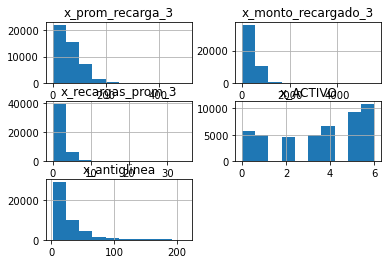

In [42]:
tad[best].hist()

In [44]:
from sklearn.feature_selection import SelectKBest

In [47]:
sk = SelectKBest(k=1)

In [48]:
sk.fit(tad[best],tad[vart])

C:\Users\VDMG015\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


SelectKBest(k=1)

In [50]:
scores = pd.DataFrame(zip(best,sk.scores_),columns=['variable','score'])
scores = scores.sort_values(by='score',ascending=False)
scores

,variable,score
4,x_antiglinea,149.691292
0,x_prom_recarga_3,18.575186
1,x_monto_recargado_3,10.880775
3,x_ACTIVO,1.354196
2,x_recargas_prom_3,0.690786


In [51]:
Xi=tad[um+varc+vart]

## Modelado

In [52]:
import numpy as np
import pandas as pd

from datetime import date
from dateutil.relativedelta import relativedelta as rd

import os
import pickle
import json

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

from functools import reduce

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score, roc_curve
from scikitplot.metrics import plot_ks_statistic,plot_roc_curve, confusion_matrix,plot_roc

from sklearn.model_selection import train_test_split,RandomizedSearchCV

from scipy.stats import ks_2samp,kruskal

cf.go_offline()
pd.set_option('display.max_columns',None)

In [56]:
sc1= StandardScaler()

In [57]:
sc = MinMaxScaler()

In [58]:
Xi.reset_index(drop=True,inplace=True)

In [59]:
sc.fit(Xi[varc])

MinMaxScaler()

In [60]:
sc1.fit(Xi[varc])

StandardScaler()

In [61]:
Xi

,linea,ancla,x_ACTIVO,x_ZERO BALANCE 1,x_antiglinea,x_cambios_eq_3,x_cambios_eq_6,x_max_monto_3,x_max_monto_6,x_max_recarga_3,x_max_recarga_6,x_min_monto_3,x_min_monto_6,x_min_recarga_3,x_min_recarga_6,x_monto_promedio_3,x_monto_promedio_6,x_monto_recargado_3,x_monto_recargado_6,x_prom_recarga_3,x_prom_recarga_6,x_recargas_3,x_recargas_6,x_recargas_prom_3,x_recargas_prom_6,x_sum_prom_recarga_3,x_sum_prom_recarga_6,churn
0,2211041593,5,3.0,3.0,39.0,2.0,2,190.0,190.0,33.333333,33.333333,0.0,0.0,16.666667,16.666667,103.333333,86.666667,310.0,520.0,26.000000,24.666667,8.0,14.0,2.666667,2.333333,78.00,148.00,0.0
1,2211049487,5,1.0,5.0,13.0,1.0,1,0.0,210.0,0.000000,8.333333,0.0,0.0,0.000000,6.666667,0.000000,61.666667,0.0,370.0,0.000000,6.833333,0.0,18.0,0.000000,3.000000,0.00,41.00,0.0
2,2211077018,5,2.0,4.0,38.0,1.0,2,30.0,90.0,16.666667,23.333333,0.0,0.0,16.666667,21.666667,16.666667,33.333333,50.0,200.0,16.666667,22.083333,2.0,8.0,0.666667,1.333333,50.00,132.50,0.0
3,2211090475,5,0.0,6.0,10.0,1.0,1,0.0,50.0,0.000000,11.666667,0.0,0.0,0.000000,11.666667,0.000000,11.666667,0.0,70.0,0.000000,11.666667,0.0,2.0,0.000000,0.333333,0.00,70.00,0.0
4,2211094929,5,3.0,3.0,38.0,1.0,2,570.0,570.0,50.000000,33.333333,60.0,0.0,10.000000,6.666667,300.000000,173.333333,900.0,1040.0,37.473333,24.570000,22.0,26.0,7.333333,4.333333,112.42,147.42,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46981,9995073480,16,6.0,0.0,36.0,1.0,2,200.0,230.0,83.333333,75.000000,150.0,100.0,50.000000,46.666667,183.333333,171.666667,550.0,1030.0,61.113333,56.806667,9.0,18.0,3.000000,3.000000,183.34,340.84,0.0
46982,9995844317,16,2.0,4.0,20.0,1.0,2,150.0,200.0,33.333333,25.000000,0.0,0.0,16.666667,16.666667,50.000000,58.333333,150.0,350.0,25.000000,20.833333,2.0,6.0,0.666667,1.000000,75.00,125.00,0.0
46983,9996402823,16,2.0,4.0,27.0,1.0,1,90.0,150.0,26.666667,26.666667,20.0,0.0,26.666667,26.666667,46.666667,58.333333,140.0,350.0,26.666667,26.666667,5.0,10.0,1.666667,1.666667,80.00,160.00,1.0
46984,9996696718,16,5.0,1.0,6.0,1.0,1,100.0,100.0,50.000000,50.000000,50.0,50.0,50.000000,50.000000,66.666667,58.333333,200.0,350.0,50.000000,50.000000,4.0,7.0,1.333333,1.166667,150.00,300.00,1.0


In [62]:
X = pd.DataFrame(sc.transform(Xi[varc]),columns=varc)
X[um] = Xi[um]
X[vart] = Xi[vart]

In [63]:
X1 = pd.DataFrame(sc1.transform(Xi[varc]),columns=varc)
X1[um] = Xi[um]
X1[vart] = Xi[vart]

In [ ]:
pi_pca = make_pipeline(StandardScaler(),PCA())
pi_pca.fit(X[varc])
Xp = pd.DataFrame(pi_pca.transform(X[varc]),columns=[f'd%i'%(i+1) for i in range(len(varc))])
Xp[um] = Xi[um]
Xp[vart] = Xi[vart]
Xp[vart[0]].replace({0:'No Fuga',1:'Fuga'},inplace=True)
Xp.head()

In [ ]:
pi_pca.steps[-1][-1].explained_variance_ratio_.cumsum()##Varianza explicada por los componentes

In [ ]:
Xp['churn'].value_counts(True)

## Partición de datos

In [64]:
Xt,Xv,yt,yv = train_test_split(X[um+varc],X[um+vart],train_size=0.7)

In [65]:
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

# Modelado

## Regresión Logística

In [66]:
modelo = LogisticRegression()

In [71]:
modelo.fit(Xt[varc],yt[vart[0]])

LogisticRegression()

### Parámetros

In [72]:
modelo.coef_

array([[ 0.14628472, -0.17835878, -1.15068581, -0.13972361,  0.26123788,
         0.44344633,  0.29233179, -0.70663797,  0.02507386,  0.1363285 ,
         0.35198875, -0.06163536,  0.6528845 ,  0.02938951, -1.65565403,
         0.02938951, -1.65565403, -0.24281688,  0.17811762,  0.91271947,
        -0.07283609,  0.91271947, -0.07283609, -0.24281688,  0.17811762]])

### Intercepto

In [73]:
modelo.intercept_

array([-1.31229831])

### Área bajo la curva ROC

### Estadístico de KS bajo diferentes puntos de corte de probabilidad

C:\Users\VDMG015\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.

C:\Users\VDMG015\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

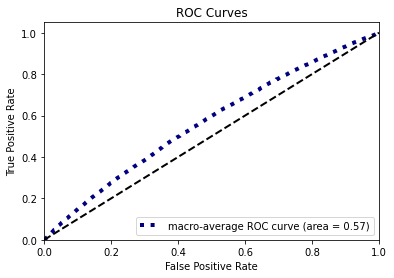

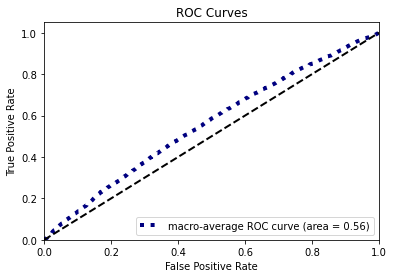

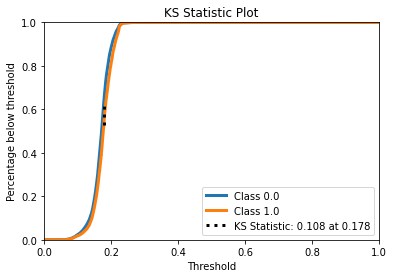

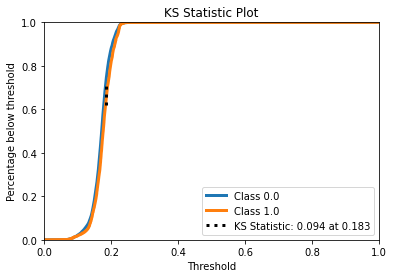

In [74]:
plot_roc_curve(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]],curves='macro')
plot_roc_curve(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]],curves='macro')

plot_ks_statistic(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]])
plot_ks_statistic(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]])

### Máquina Vector Soporte

In [75]:
modelo = SVC(probability=True)

In [81]:
modelo.fit(Xt[varc],yt[vart[0]])

SVC(probability=True)

### Área bajo la curva ROC

### Estadístico de KS bajo diferentes puntos de corte de probabilidad

C:\Users\VDMG015\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.

C:\Users\VDMG015\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

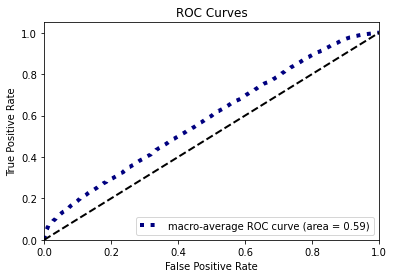

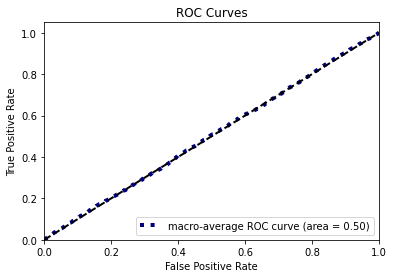

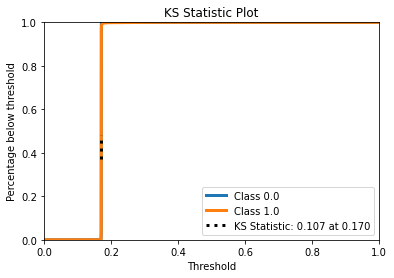

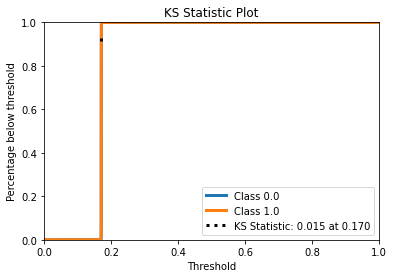

In [83]:
plot_roc_curve(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]],curves='macro')
plot_roc_curve(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]],curves='macro')

plot_ks_statistic(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]])
plot_ks_statistic(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]])

### Red Neuronal

In [ ]:
modelo = MLPClassifier()

In [ ]:
%%time
modelo.fit(Xt[varc],yt[vart[0]])

### Área bajo la curva ROC

### Estadístico de KS bajo diferentes puntos de corte de probabilidad

In [ ]:
plot_roc_curve(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]],curves='macro')
plot_roc_curve(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]],curves='macro')

plot_ks_statistic(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]])
plot_ks_statistic(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]])

In [ ]:
%%time
modelo.fit(Xt[best],yt[vart[0]])

### Área bajo la curva ROC

### Estadístico de KS bajo diferentes puntos de corte de probabilidad

In [ ]:
plot_roc_curve(y_probas=modelo.predict_proba(Xt[best]),y_true=yt[vart[0]],curves='macro')
plot_roc_curve(y_probas=modelo.predict_proba(Xv[best]),y_true=yv[vart[0]],curves='macro')

plot_ks_statistic(y_probas=modelo.predict_proba(Xt[best]),y_true=yt[vart[0]])
plot_ks_statistic(y_probas=modelo.predict_proba(Xv[best]),y_true=yv[vart[0]])

### XGB

In [ ]:
gradilla_hp={"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

grid = RandomizedSearchCV(cv=3,verbose=True,
                          estimator=modelo,
                          n_jobs=-1,
                          scoring='roc_auc',
                          param_distributions=gradilla_hp,
                          n_iter=100)

grid.fit(Xt[varc],yt[vart[0]])

modelo = grid.best_estimator_
modelo

grid.best_params_

grid.best_score_

modelo.fit(Xt[varc],yt[vart[0]])

In [ ]:
plot_roc_curve(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]],curves='macro')
plot_roc_curve(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]],curves='macro')

plot_ks_statistic(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]])
plot_ks_statistic(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]])

In [ ]:
d=pd.DataFrame(modelo.predict_proba(Xv[varc]))

In [ ]:
tn, fp, fn, tp = confusion_matrix(yv[vart[0]],modelo.predict(Xv[varc])).ravel()

In [ ]:
tn, fp, fn, tp

In [80]:
confusion_matrix(yv[vart[0]],modelo.predict(Xv[['x_antiglinea','x_prom_recarga_3']]))

array([[11759,     0],
       [ 2337,     0]], dtype=int64)

In [ ]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [ ]:
yv['proba']=pd.DataFrame(modelo.predict_proba(Xv[varc]))[1]

In [ ]:
fpr, tpr, threshold = roc_curve(yv[vart[0]], yv['proba'])

In [ ]:
# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(yv[vart[0]], yv['proba'])


In [ ]:
threshold[0]

In [ ]:
yv['pred']=yv['proba'].map(lambda x: 1 if x > threshold[0] else 0)

In [ ]:
confusion_matrix(yv[vart[0]], yv['pred'])

In [ ]:
confusion_matrix(yt[vart[0]],modelo.predict(Xt[varc]))

In [ ]:
152/295, 518/2099

In [ ]:
37/295, 27/2099

In [ ]:
from xgboost.sklearn import XGBClassifier
modelo = XGBClassifier()

In [ ]:
modelo.fit(Xt[varc], yt[vart[0]])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
yp = modelo.predict(Xv[varc])
cm = confusion_matrix(yv[vart[0]], yp)
print(cm)
accuracy_score(yv[vart[0]], yp)

In [ ]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = modelo, X = Xt[varc], y = yt[vart[0]], cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

In [ ]:
plot_roc(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]])
plot_roc(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]])

plot_ks_statistic(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]])
plot_ks_statistic(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]])

### Bosque Aleatorio

In [ ]:
modelo = RandomForestClassifier()

In [ ]:
%%time
modelo.fit(Xt[varc],yt[vart[0]])

### Área bajo la curva ROC

### Estadístico de KS bajo diferentes puntos de corte de probabilidad

In [ ]:
plot_roc_curve(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]],curves='macro')
plot_roc_curve(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]],curves='macro')

plot_ks_statistic(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]])
plot_ks_statistic(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]])

### Hiperparametrización

In [ ]:
gradilla_hp = dict(n_estimators = range(10,200,10),
                   criterion = ["gini", "entropy"],
                   max_depth = range(2,10)
                  )

grid = RandomizedSearchCV(cv=4,verbose=True,
                          estimator=modelo,
                          n_jobs=-1,
                          scoring='roc_auc',
                          param_distributions=gradilla_hp,
                          n_iter=100)

grid.fit(Xt[varc],yt[vart[0]])

modelo = grid.best_estimator_

print(grid.best_params_)

print(grid.best_score_)

modelo.fit(Xt[varc],yt[vart[0]])

### Área bajo la curva ROC

### Estadístico de KS bajo diferentes puntos de corte de probabilidad

In [ ]:
plot_roc_curve(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]],curves='macro')
plot_roc_curve(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]],curves='macro')

plot_ks_statistic(y_probas=modelo.predict_proba(Xt[varc]),y_true=yt[vart[0]])
plot_ks_statistic(y_probas=modelo.predict_proba(Xv[varc]),y_true=yv[vart[0]])

### Árbol de Decisión

In [ ]:
modelo = DecisionTreeClassifier()

In [ ]:
modelo.fit(Xt[varc1],yt[vart[0]])

In [ ]:
plot_roc_curve(y_probas=modelo.predict_proba(Xt[varc1]),y_true=yt[vart[0]],curves='macro')
plot_roc_curve(y_probas=modelo.predict_proba(Xv[varc1]),y_true=yv[vart[0]],curves='macro')

plot_ks_statistic(y_probas=modelo.predict_proba(Xt[varc1]),y_true=yt[vart[0]])
plot_ks_statistic(y_probas=modelo.predict_proba(Xv[varc1]),y_true=yv[vart[0]])

### Hiperparametrización

In [ ]:
gradilla_hp = dict(
                   criterion = ["gini", "entropy"],
                   max_depth = range(2,50)
                  )

grid = RandomizedSearchCV(cv=4,verbose=True,
                          estimator=modelo,
                          n_jobs=-1,
                          scoring='roc_auc',
                          param_distributions=gradilla_hp,
                          n_iter=200)

grid.fit(Xt[varc1],yt[vart[0]])

modelo = grid.best_estimator_

print(grid.best_params_)

print(grid.best_score_)

modelo.fit(Xt[varc1],yt[vart[0]])

### Área bajo la curva ROC

### Estadístico de KS bajo diferentes puntos de corte de probabilidad

In [ ]:
plot_roc_curve(y_probas=modelo.predict_proba(Xt[varc1]),y_true=yt[vart[0]],curves='macro')
plot_roc_curve(y_probas=modelo.predict_proba(Xv[varc1]),y_true=yv[vart[0]],curves='macro')

plot_ks_statistic(y_probas=modelo.predict_proba(Xt[varc1]),y_true=yt[vart[0]])
plot_ks_statistic(y_probas=modelo.predict_proba(Xv[varc1]),y_true=yv[vart[0]])

In [ ]:
.